In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy.fft import rfft as fft, rfftfreq as fftfreq
import scipy.signal as signal
def dB(x, ref=1): return 20*np.log10(np.abs(x)/ref)

In [2]:
file_full_responses = h5py.File('full_responses.h5', mode='r')
file_on_axis_responses = h5py.File('on_axis_responses.h5', mode='r')
file_directivities = h5py.File('directivities.h5', mode='r')

## Plot on-axis responses
This shows how to plot the on-axis responses of all transducers of a certain type.
In order to properly see and compare the different responses it is nessessary to smooth the data.

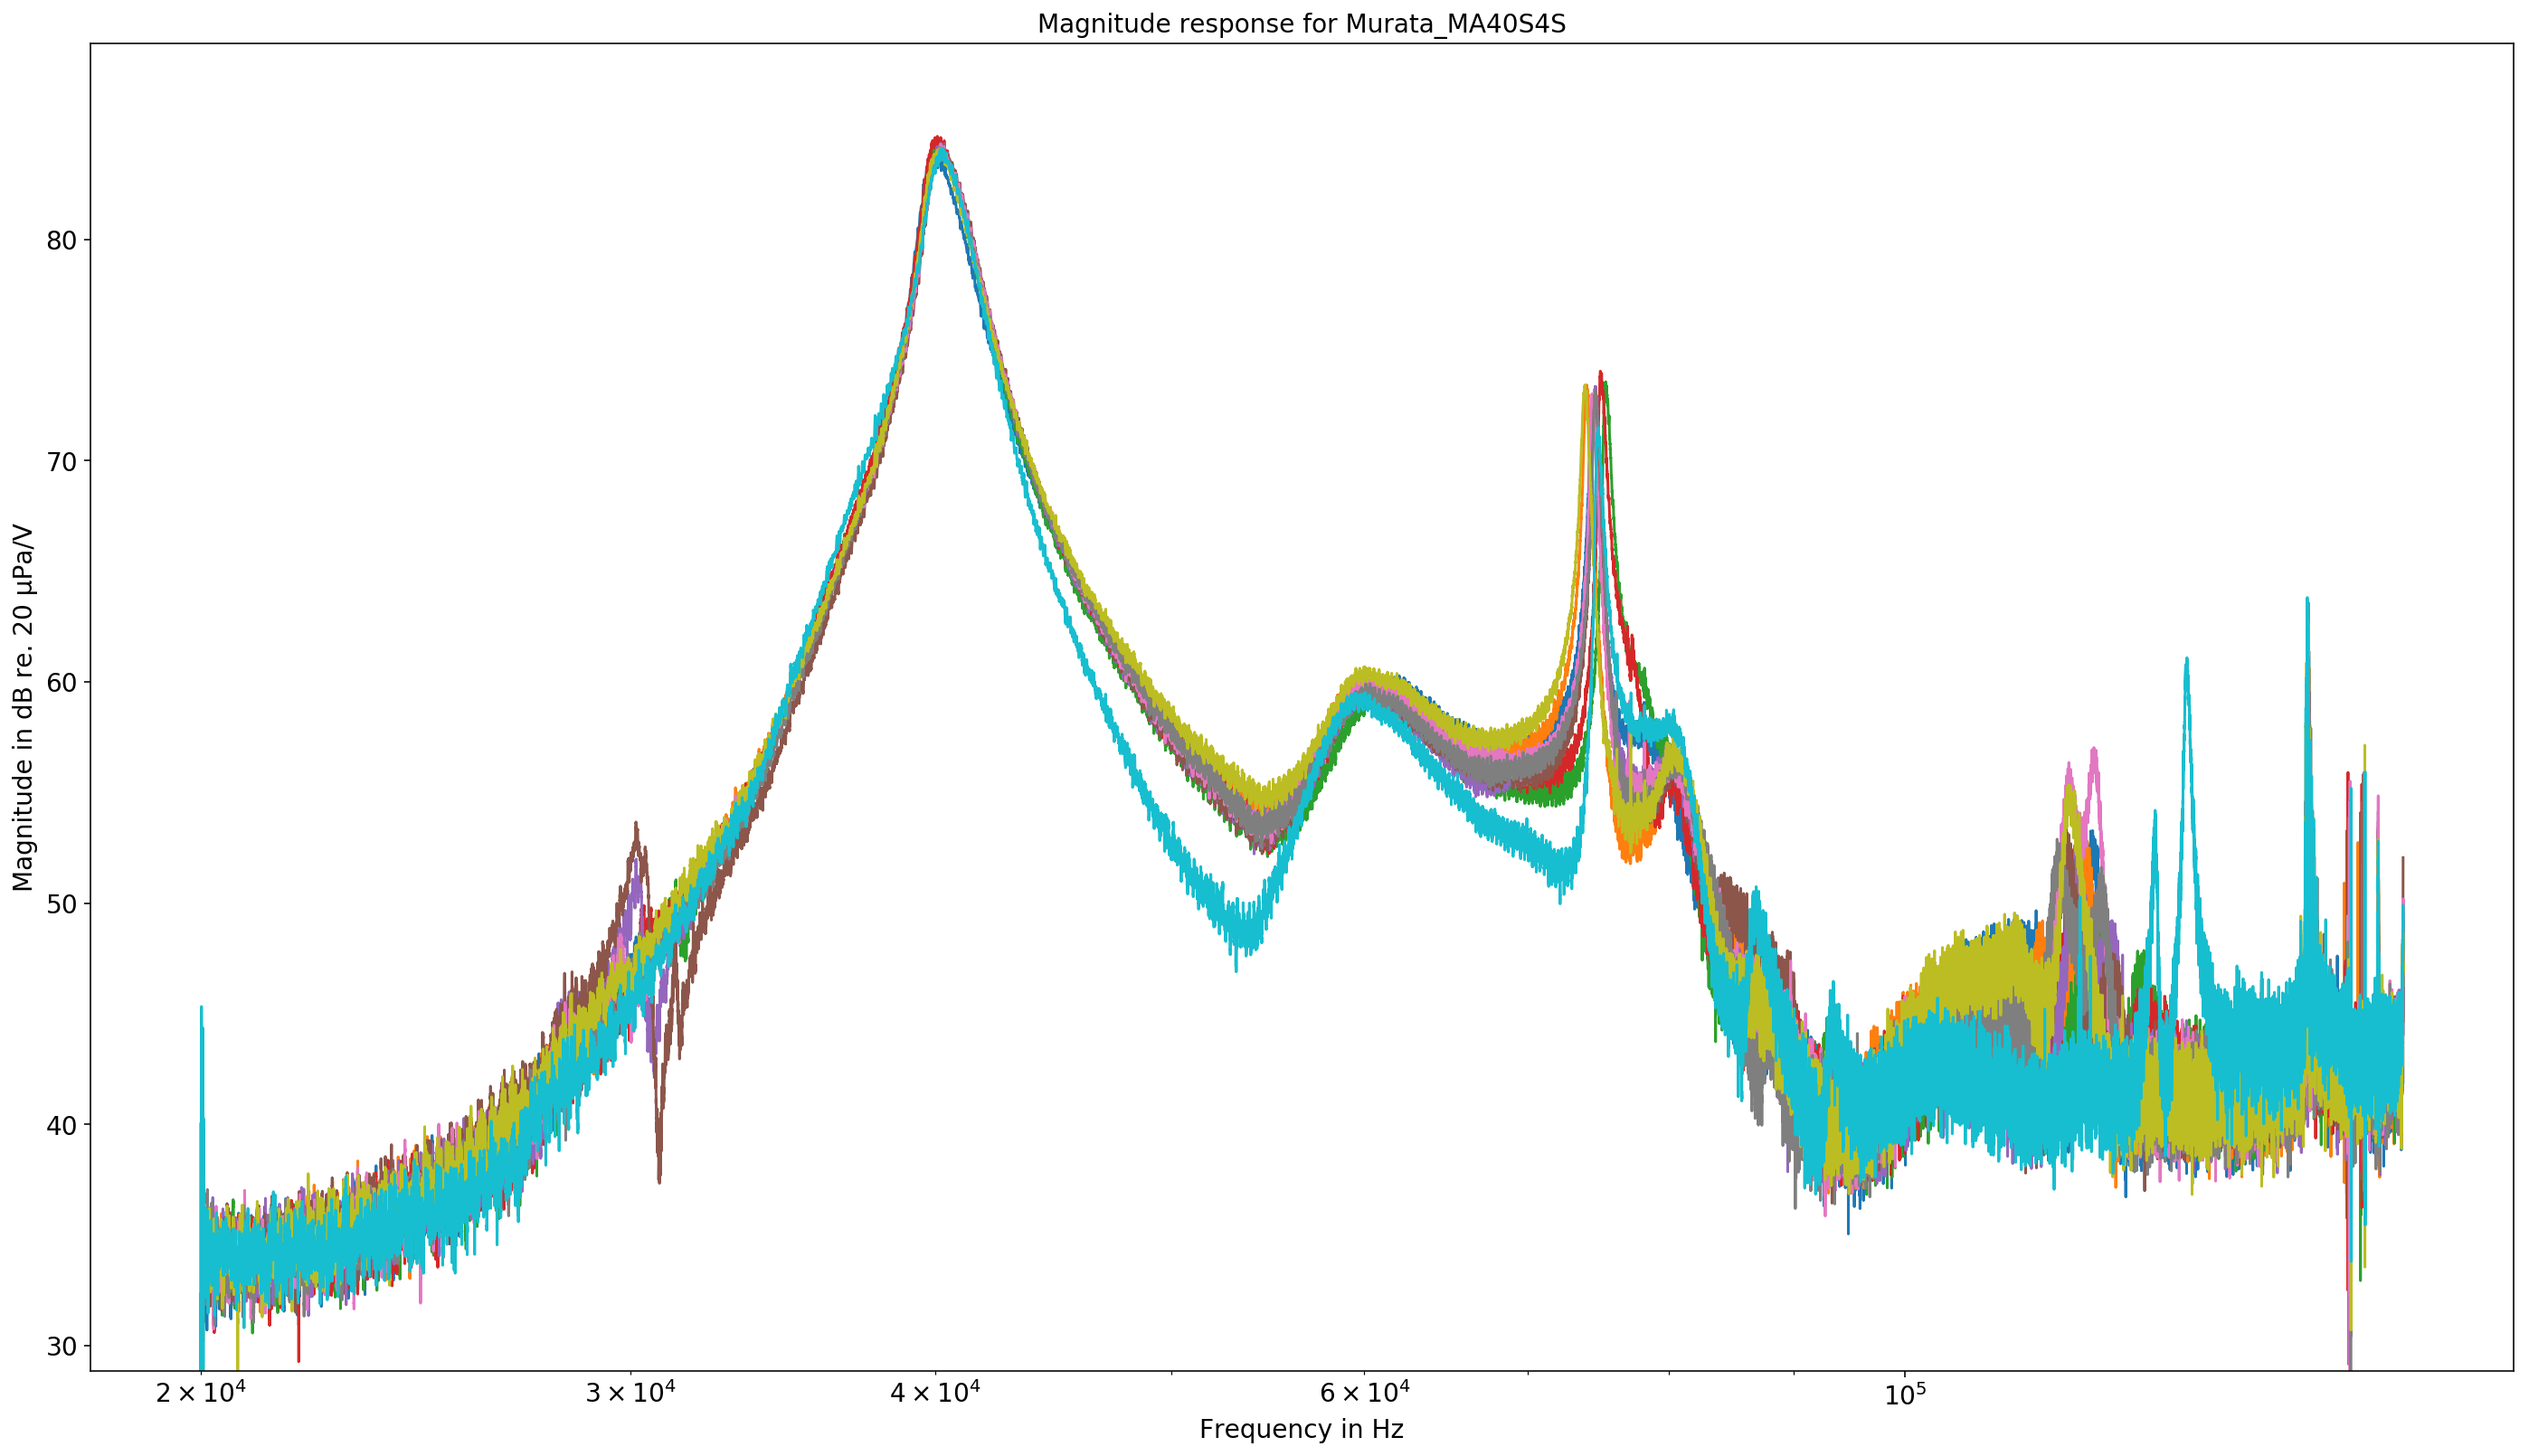

In [85]:
Type = 'Murata_MA40S4S'
group = file_on_axis_responses[Type]

for name, dataset in group.items():
    scaling = dataset.attrs['Scaling coefficients']
    reference = (dataset[0] * scaling[0][1] + scaling[0][0]) * dataset.attrs['Amplifier gain']
    pressure = (dataset[1, :] * scaling[1][1] + scaling[1][0]) / dataset.attrs['Calibration']
    response = fft(pressure) / fft(reference) * dataset.attrs['Distance']
    
    f = fftfreq(dataset.shape[1], 1/dataset.attrs['Sampling frequency'])
    f_idx = (f >= min(dataset.attrs['Sweep range'])) & (f <= max(dataset.attrs['Sweep range']))
    
    magnitude = signal.savgol_filter(abs(response[f_idx]), 101, 5)
    plt.semilogx(f[f_idx], dB(magnitude, 2e-5))
plt.xlabel('Frequency in Hz')
plt.ylabel('Magnitude in dB re. 20 µPa/V')
plt.title('Magnitude response for {}'.format(Type))
plt.ylim(ymin=plt.ylim()[1]-60)
plt.savefig('on_axis_{}.pdf'.format(Type))
plt.show()

## Plot directivities
This shows how to load and plot the directivities of all transducers of a certain type for a specified frequency. The directivities are calculated using the same approach as the on-axis response calculations above, applied for each angle separately.

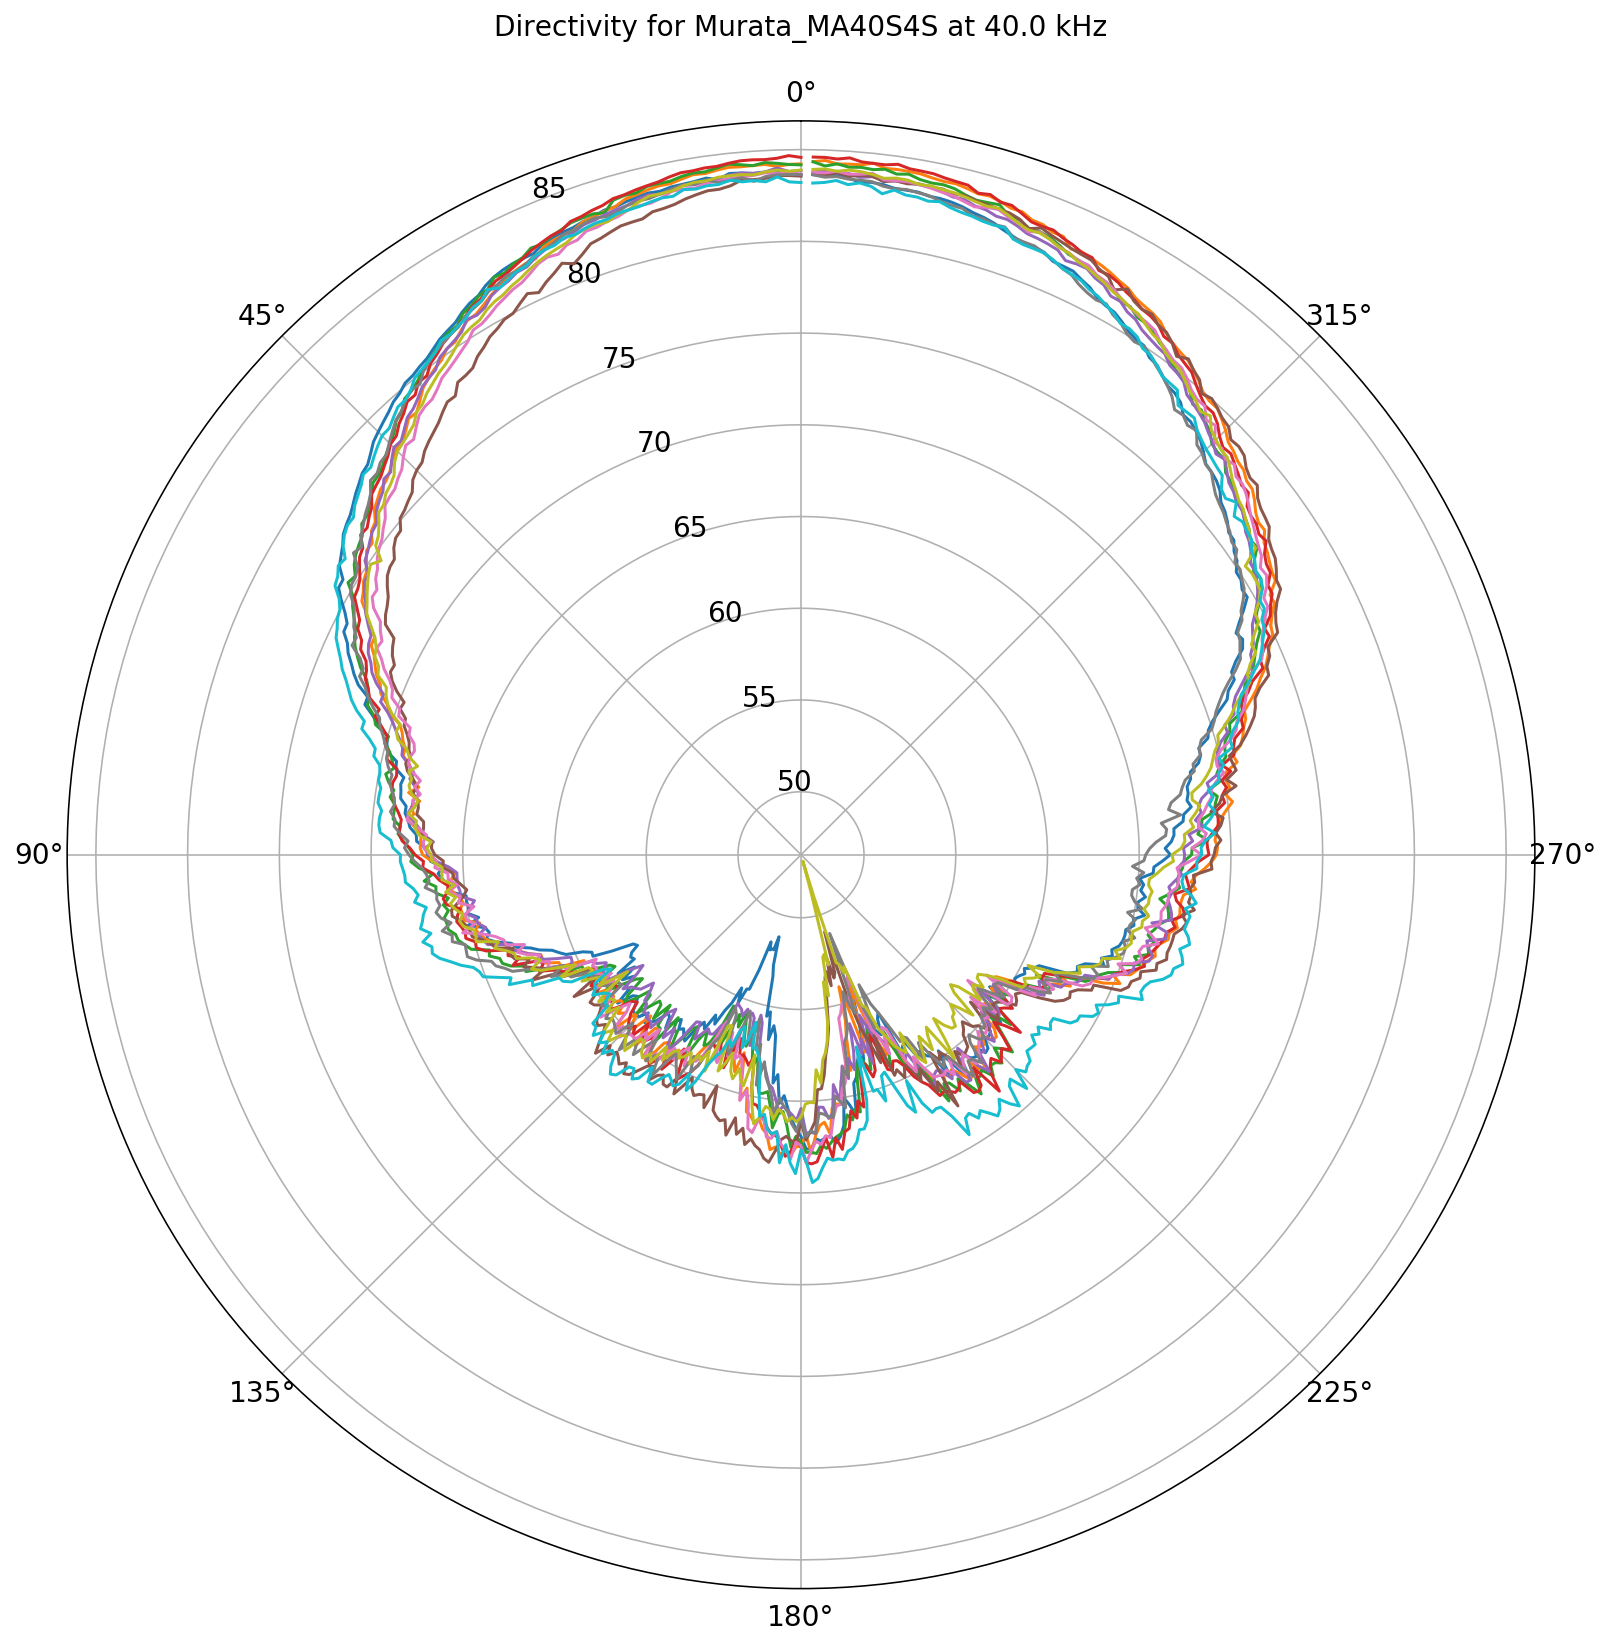

In [86]:
f0 = 40e3
Type = 'Murata_MA40S4S'
group = file_directivities[Type]

for name, dataset in group.items():
    num_freqs, num_angles = dataset.shape
    f = np.linspace(dataset.attrs['Sweep range'][0], dataset.attrs['Sweep range'][1], num_freqs)
    f_idx = np.argmin(abs(f-f0))
    angles = np.arange(num_angles) * dataset.attrs['Angular resolution']
    plt.polar(np.radians(angles), dB(dataset[f_idx], 2e-5))
plt.gca().set_theta_offset(np.pi/2)
plt.title('Directivity for {} at {} kHz'.format(Type, f0/1e3))
plt.ylim(ymin=plt.ylim()[1]-40)
plt.gcf().set_figwidth(plt.gcf().get_figheight())
plt.savefig('directivity_{}_{}kHz.pdf'.format(Type, int(f0/1e3)))
plt.show()